# yolo를 이용한 과일 감지


## 모듈 불러오기 

In [1]:
import json
import pandas as pd
import cv2
import numpy as np
import xmltodict
import glob
import xml.etree.ElementTree as ET
import yaml
import os
import shutil
from PIL import Image

## xml구조 파악하기 

In [2]:
import json

with open("./train_zip/train/apple_2.xml",'r') as f:
    xmlString = f.read()
print(xmlString)

<annotation>
	<folder>train</folder>
	<filename>apple_2.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_2.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>250</width>
		<height>250</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>37</xmin>
			<ymin>52</ymin>
			<xmax>205</xmax>
			<ymax>222</ymax>
		</bndbox>
	</object>
</annotation>



#json으로 변환하는 방법도 있음)
"""
jsonString = json.dumps(xmltodict.parse(xmlString), indent=4)
 
print("\nJSON output(output.json):")
print(jsonString)
 
with open("xml_to_json.json", 'w') as f:
    f.write(jsonString)
""" 

In [3]:
import glob
name = []
for i in glob.glob('C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train_zip/train'+'/*.xml'):
    name.append(i.split('/')[-1][:-4])
    #print(i.split('\\')[-1][:-4])

## xml파일을 데이터프레임으로 변환 

In [4]:
import xml.etree.ElementTree as ET
df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

for idx, anno in enumerate(glob.glob('C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train_zip/train'+'/*.xml')):
    trees = ET.parse(anno)#경로찾기
    
    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():  #태그찾기
        #print(item)
               
        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width = int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))
                    
        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]] 
                    df['name'] += [anno.split('\\')[-1][0:-4]]
                    
                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]
                            
                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]
                        

                        


In [5]:
df1 = pd.DataFrame(df)
df1


name   label  width  height  xmin  ymin  xmax  ymax
0      apple_1   apple      0       0     8    15   331   349
1     apple_10   apple   1500    1500    56    99  1413  1419
2     apple_11   apple    652     436   213    33   459   258
3     apple_11   apple    652     436     1    30   188   280
4     apple_11   apple    652     436   116     5   337   220
..         ...     ...    ...     ...   ...   ...   ...   ...
460  orange_76  orange   1620    1080   494     1  1452   741
461  orange_76  orange   1620    1080   822   643  1620  1066
462   orange_8  orange    600     393    42    86   282   330
463   orange_8  orange    600     393   291    81   545   348
464   orange_9  orange    500     427    35    96   268   315

[465 rows x 8 columns]

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    465 non-null    object
 1   label   465 non-null    object
 2   width   465 non-null    int64 
 3   height  465 non-null    int64 
 4   xmin    465 non-null    int64 
 5   ymin    465 non-null    int64 
 6   xmax    465 non-null    int64 
 7   ymax    465 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 29.2+ KB


In [7]:
df1['label'].unique()

array(['apple', 'banana', 'orange'], dtype=object)

In [8]:
label_map = { 'orange': 0,
            'apple': 1,
            'banana': 2}
df1['class'] = df1['label'].map(label_map)
#해당 label값을 해당하는 숫자 값으로 class열에 새로 추가

In [9]:
df1

name   label  width  height  xmin  ymin  xmax  ymax  class
0      apple_1   apple      0       0     8    15   331   349      1
1     apple_10   apple   1500    1500    56    99  1413  1419      1
2     apple_11   apple    652     436   213    33   459   258      1
3     apple_11   apple    652     436     1    30   188   280      1
4     apple_11   apple    652     436   116     5   337   220      1
..         ...     ...    ...     ...   ...   ...   ...   ...    ...
460  orange_76  orange   1620    1080   494     1  1452   741      0
461  orange_76  orange   1620    1080   822   643  1620  1066      0
462   orange_8  orange    600     393    42    86   282   330      0
463   orange_8  orange    600     393   291    81   545   348      0
464   orange_9  orange    500     427    35    96   268   315      0

[465 rows x 9 columns]

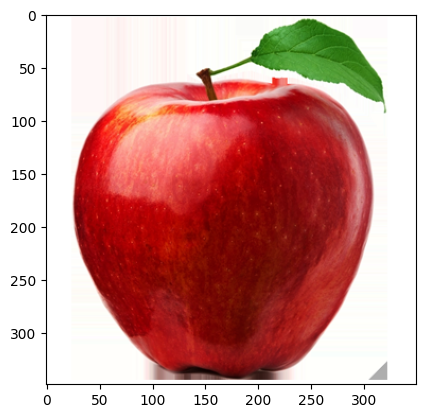

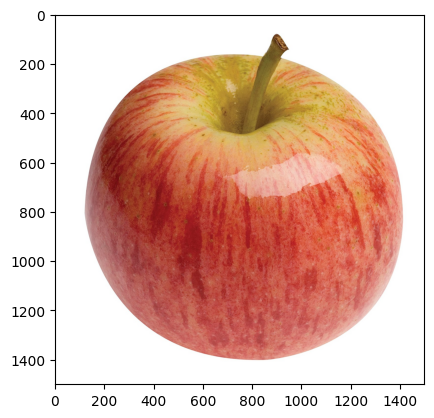

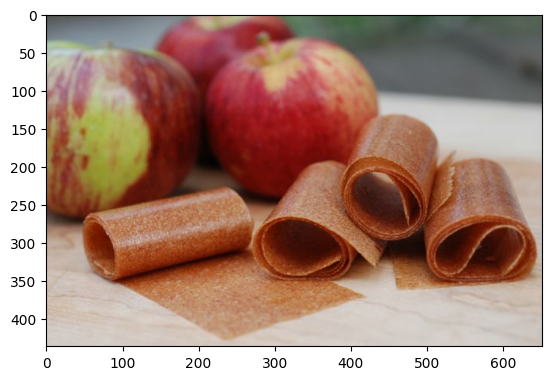

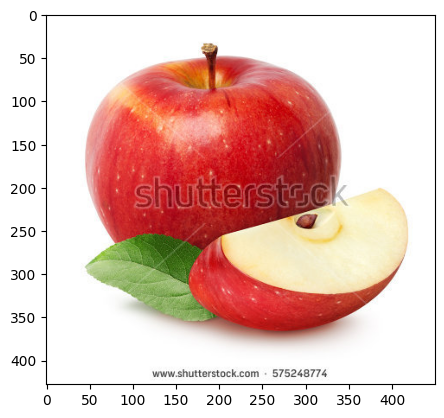

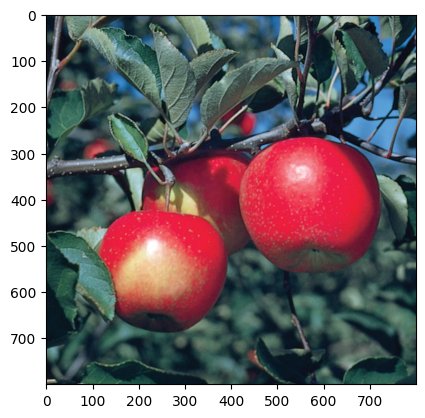

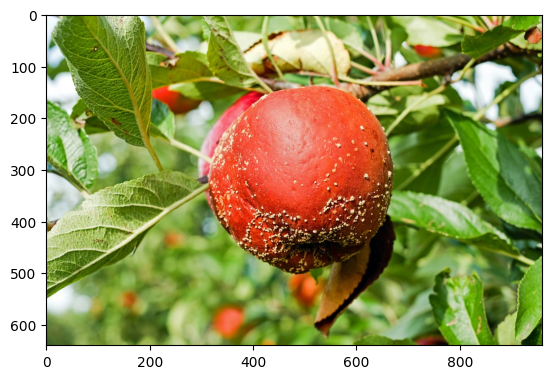

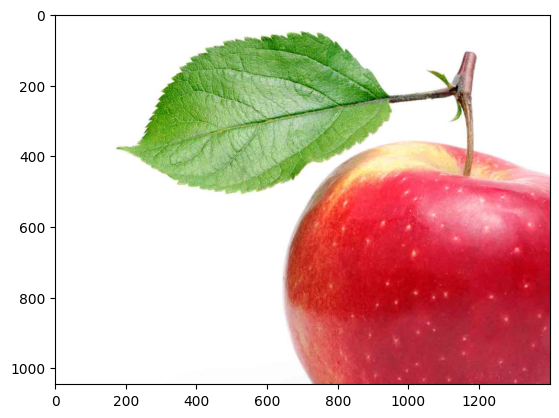

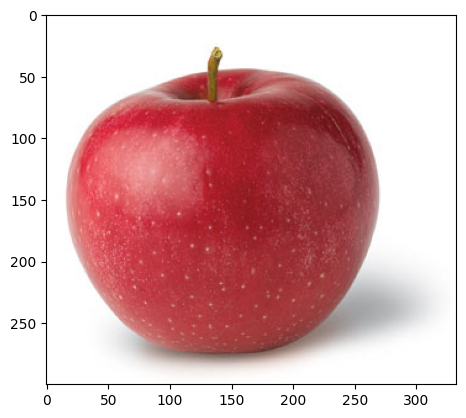

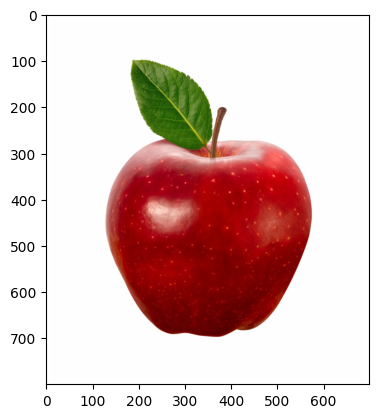

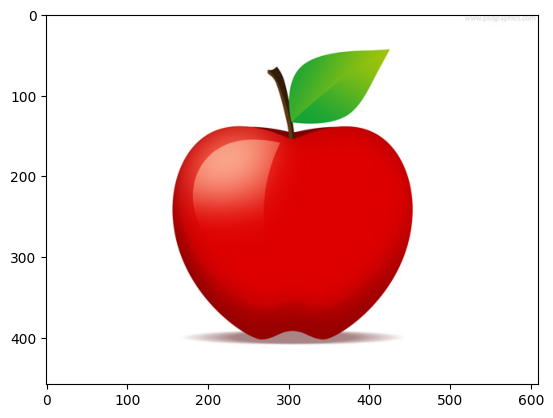

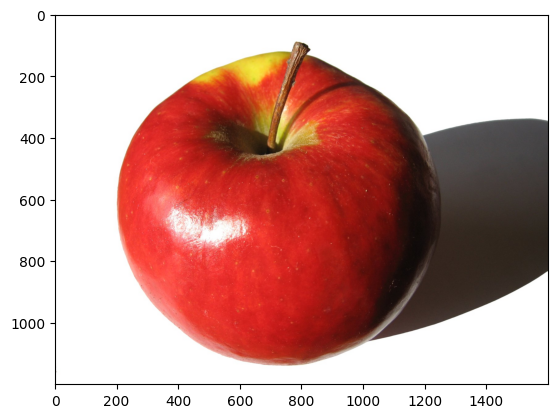

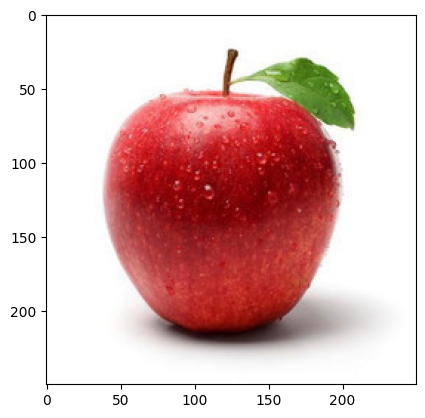

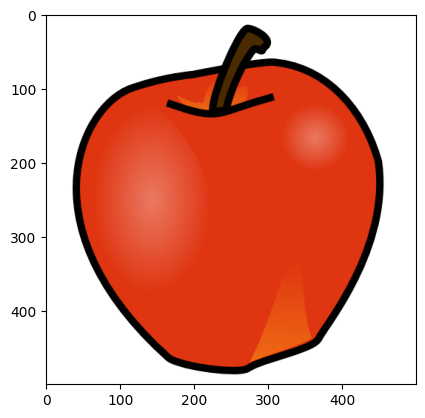

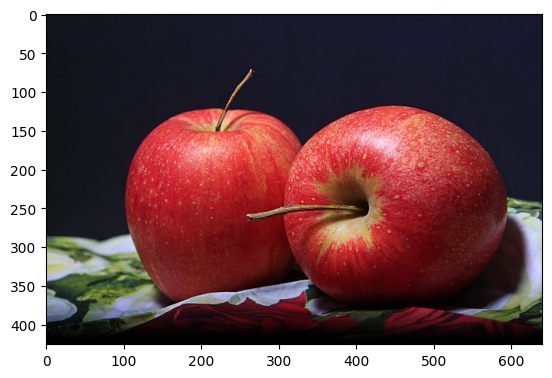

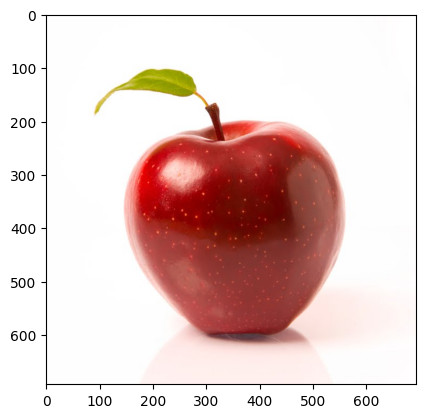

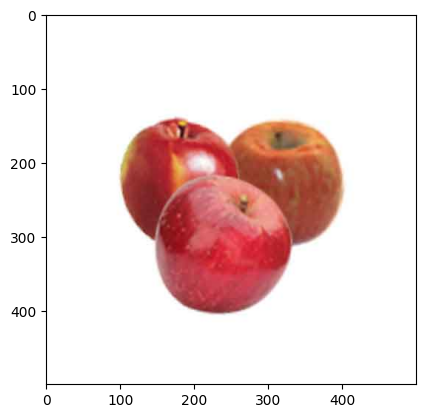

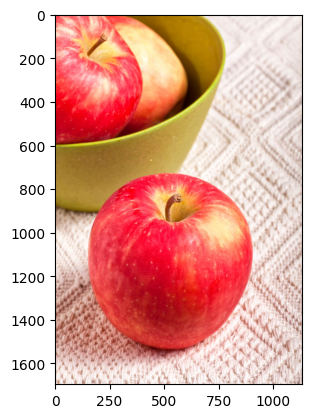

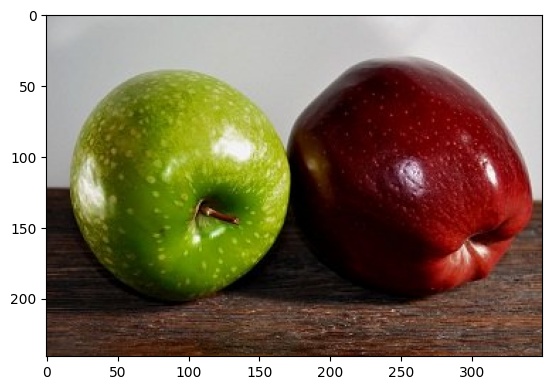

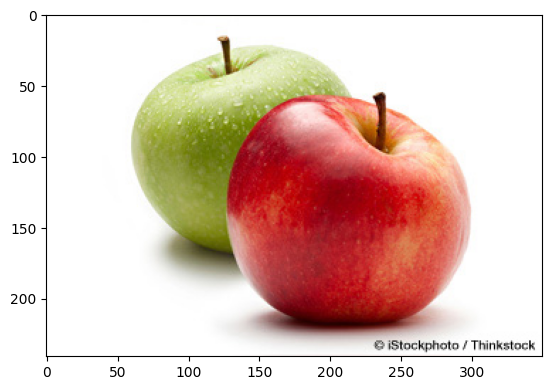

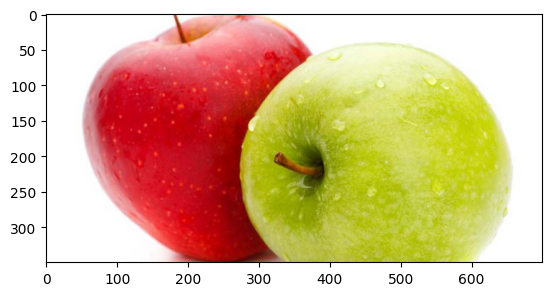

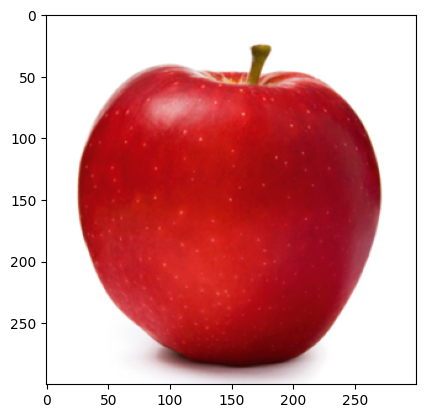

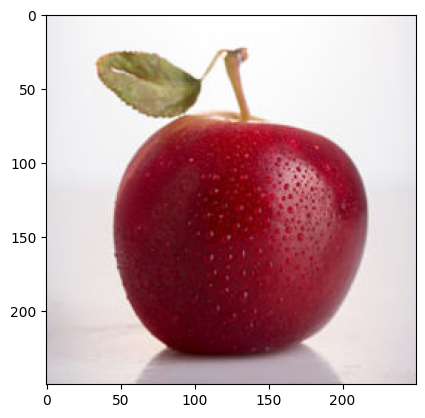

KeyboardInterrupt: 

In [52]:
import matplotlib.pyplot as plt

for i in glob.glob('./train_zip/train/'+'*.jpg'):
    img = cv2.imread(i)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

bounding box가 그려진 이미지 표시해보기

In [10]:
test_img = cv2.imread('./train_zip/train/orange_9.jpg')
cv2.rectangle(test_img, (df1['xmin'][464], df1['ymin'][464]), (df1['xmax'][464], df1['ymax'][464]), (0, 255, 0), 2)
cv2.imshow("Image with Bounding Box", test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [54]:
df1.dropna(inplace=True)
df1[['xmin', 'ymin', 'xmax', 'ymax']] = df1[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')
df1

name   label  width  height  xmin  ymin  xmax  ymax  class
0      apple_1   apple      0       0     8    15   331   349      1
1     apple_10   apple   1500    1500    56    99  1413  1419      1
2     apple_11   apple    652     436   213    33   459   258      1
3     apple_11   apple    652     436     1    30   188   280      1
4     apple_11   apple    652     436   116     5   337   220      1
..         ...     ...    ...     ...   ...   ...   ...   ...    ...
460  orange_76  orange   1620    1080   494     1  1452   741      0
461  orange_76  orange   1620    1080   822   643  1620  1066      0
462   orange_8  orange    600     393    42    86   282   330      0
463   orange_8  orange    600     393   291    81   545   348      0
464   orange_9  orange    500     427    35    96   268   315      0

[465 rows x 9 columns]

yolo에맞게 bounding box 중심점과 가로세로 중심점 찾기

In [11]:
for i in range(len(df1)):
    width = df1['width'][i]
    height = df1['height'][i]
    df1.loc[i,'x_center'] = (df1['xmin'][i]+df1['xmax'][i])/(width*2)
    df1.loc[i,'y_center'] = (df1['ymin'][i]+df1['ymax'][i])/(height*2)
    df1.loc[i,'box_width'] = (df1['xmax'][i]-df1['xmin'][i])/width
    df1.loc[i,'box_height'] = (df1['ymax'][i]-df1['ymin'][i])/height

df1

C:\Users\Administrator\AppData\Local\Temp\ipykernel_28080\2625615943.py:4: RuntimeWarning: divide by zero encountered in longlong_scalars
  df1.loc[i,'x_center'] = (df1['xmin'][i]+df1['xmax'][i])/(width*2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28080\2625615943.py:5: RuntimeWarning: divide by zero encountered in longlong_scalars
  df1.loc[i,'y_center'] = (df1['ymin'][i]+df1['ymax'][i])/(height*2)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28080\2625615943.py:6: RuntimeWarning: divide by zero encountered in longlong_scalars
  df1.loc[i,'box_width'] = (df1['xmax'][i]-df1['xmin'][i])/width
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28080\2625615943.py:7: RuntimeWarning: divide by zero encountered in longlong_scalars
  df1.loc[i,'box_height'] = (df1['ymax'][i]-df1['ymin'][i])/height
C:\Users\Administrator\AppData\Local\Temp\ipykernel_28080\2625615943.py:4: RuntimeWarning: divide by zero encountered in longlong_scalars
  df1.loc[i,'x_center'] = (df1['xmin'][i]

name   label  width  height  xmin  ymin  xmax  ymax  class  \
0      apple_1   apple      0       0     8    15   331   349      1   
1     apple_10   apple   1500    1500    56    99  1413  1419      1   
2     apple_11   apple    652     436   213    33   459   258      1   
3     apple_11   apple    652     436     1    30   188   280      1   
4     apple_11   apple    652     436   116     5   337   220      1   
..         ...     ...    ...     ...   ...   ...   ...   ...    ...   
460  orange_76  orange   1620    1080   494     1  1452   741      0   
461  orange_76  orange   1620    1080   822   643  1620  1066      0   
462   orange_8  orange    600     393    42    86   282   330      0   
463   orange_8  orange    600     393   291    81   545   348      0   
464   orange_9  orange    500     427    35    96   268   315      0   

     x_center  y_center  box_width  box_height  
0         inf       inf        inf         inf  
1    0.489667  0.506000   0.904667    0.880000  
2    0.515337  0.333716   0.377301    0.516055  
3    0.144939  0.355505   0.286810    0.573394  
4    0.347393  0.258028   0.338957    0.493119  
..        ...       ...        ...         ...  
460  0.600617  0.343519   0.591358    0.685185  
461  0.753704  0.791204   0.492593    0.391667  
462  0.270000  0.529262   0.400000    0.620865  
463  0.696667  0.545802   0.423333    0.679389  
464  0.303000  0.481265   0.466000    0.512881  

[465 rows x 13 columns]

In [12]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1.dropna(inplace=True)
df1

name   label  width  height  xmin  ymin  xmax  ymax  class  \
1     apple_10   apple   1500    1500    56    99  1413  1419      1   
2     apple_11   apple    652     436   213    33   459   258      1   
3     apple_11   apple    652     436     1    30   188   280      1   
4     apple_11   apple    652     436   116     5   337   220      1   
5     apple_12   apple    450     428    43    21   350   353      1   
..         ...     ...    ...     ...   ...   ...   ...   ...    ...   
460  orange_76  orange   1620    1080   494     1  1452   741      0   
461  orange_76  orange   1620    1080   822   643  1620  1066      0   
462   orange_8  orange    600     393    42    86   282   330      0   
463   orange_8  orange    600     393   291    81   545   348      0   
464   orange_9  orange    500     427    35    96   268   315      0   

     x_center  y_center  box_width  box_height  
1    0.489667  0.506000   0.904667    0.880000  
2    0.515337  0.333716   0.377301    0.516055  
3    0.144939  0.355505   0.286810    0.573394  
4    0.347393  0.258028   0.338957    0.493119  
5    0.436667  0.436916   0.682222    0.775701  
..        ...       ...        ...         ...  
460  0.600617  0.343519   0.591358    0.685185  
461  0.753704  0.791204   0.492593    0.391667  
462  0.270000  0.529262   0.400000    0.620865  
463  0.696667  0.545802   0.423333    0.679389  
464  0.303000  0.481265   0.466000    0.512881  

[420 rows x 13 columns]

In [13]:
df = df1[['class','x_center','y_center','box_width','box_height']]
df

class  x_center  y_center  box_width  box_height
1        1  0.489667  0.506000   0.904667    0.880000
2        1  0.515337  0.333716   0.377301    0.516055
3        1  0.144939  0.355505   0.286810    0.573394
4        1  0.347393  0.258028   0.338957    0.493119
5        1  0.436667  0.436916   0.682222    0.775701
..     ...       ...       ...        ...         ...
460      0  0.600617  0.343519   0.591358    0.685185
461      0  0.753704  0.791204   0.492593    0.391667
462      0  0.270000  0.529262   0.400000    0.620865
463      0  0.696667  0.545802   0.423333    0.679389
464      0  0.303000  0.481265   0.466000    0.512881

[420 rows x 5 columns]

In [14]:
train_dir = "C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train_zip/train"
label_dir = "C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train/label"
image_dir = "C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train/image"

In [15]:
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), label_dir)
for filename in os.listdir(train_dir):
    if filename.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, filename))
        image = image.convert("RGB")
        new_filename = os.path.splitext(filename)[0] + ".jpeg"
        image.save(os.path.join(image_dir, new_filename), "JPEG")

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
img_file_path = []
for img in os.listdir(image_dir):
    image  = cv2.imread(os.path.join(image_dir, img), 0)
    img_file_path.append(f'{img}')

In [17]:
image_dir

'C:/Users/Administrator/Desktop/duhee/Object_Detection-main/train/image'

In [18]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(img_file_path, test_size=0.15, random_state=101)

In [19]:
train

['banana_43.jpeg',
 'apple_42.jpeg',
 'banana_29.jpeg',
 'orange_22.jpeg',
 'apple_46.jpeg',
 'banana_33.jpeg',
 'orange_21.jpeg',
 'orange_27.jpeg',
 'mixed_1.jpeg',
 'mixed_7.jpeg',
 'orange_33.jpeg',
 'banana_12.jpeg',
 'apple_40.jpeg',
 'banana_54.jpeg',
 'orange_43.jpeg',
 'apple_54.jpeg',
 'apple_3.jpeg',
 'apple_49.jpeg',
 'banana_14.jpeg',
 'banana_75.jpeg',
 'banana_51.jpeg',
 'apple_23.jpeg',
 'orange_9.jpeg',
 'orange_49.jpeg',
 'apple_56.jpeg',
 'orange_70.jpeg',
 'apple_11.jpeg',
 'apple_32.jpeg',
 'apple_9.jpeg',
 'apple_7.jpeg',
 'orange_16.jpeg',
 'apple_6.jpeg',
 'apple_70.jpeg',
 'orange_50.jpeg',
 'orange_69.jpeg',
 'apple_62.jpeg',
 'orange_38.jpeg',
 'orange_10.jpeg',
 'banana_72.jpeg',
 'orange_75.jpeg',
 'apple_24.jpeg',
 'orange_17.jpeg',
 'orange_55.jpeg',
 'orange_18.jpeg',
 'mixed_12.jpeg',
 'orange_52.jpeg',
 'apple_57.jpeg',
 'apple_26.jpeg',
 'apple_66.jpeg',
 'banana_56.jpeg',
 'apple_72.jpeg',
 'banana_13.jpeg',
 'apple_10.jpeg',
 'apple_5.jpeg',
 'apple

In [20]:
def copy_image_file(image_items, folder_name):
    for image in image_items:
        img = Image.open(f'{image_dir}/{image}')
        _ = img.save(f'C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/{folder_name}/images/{image}')
copy_image_file(train, 'train')
copy_image_file(val, 'val')

In [21]:
def copy_label(label_items, folder_name):
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df1[df1.name == name]

        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(str(row['class'])+" "+str(row['x_center'])+" "+str(row['y_center'])+" "+ str(row['box_width'])+" "+str(row['box_height']))

        text = "\n".join(box_list)
        with open(f'C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)
copy_label(train, 'train')
copy_label(val, 'val')

In [22]:
yaml_text = {
    "train": "C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/train/images",
    "val" : "C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/val/images",
    "nc" : 3,
    "names":['apple','banana','orange']  
}
with open('C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/data.yaml', 'w') as f:
    yaml.dump(yaml_text, f)

In [23]:
!python C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/train.py --epochs 50 --batch 32 --data C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=C:/Users/Administrator/Desktop/duhee/Object_Detection-main/yolov5/data/data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-178-ga199480 Python-3.9.15 torch-2.0.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4